# Outline

This notebook is an outline of the project, including introducing basic properties of the simulated data and applied methods.

This notebook create some panels that are part of Figure 1 of the paper version of this project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_powerlaw
from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_power_spectra
from neurodsp.plts.time_series import plot_multi_time_series
from neurodsp.utils import set_random_seed

from fooof.utils import trim_spectrum

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_15112/1674923184.py:11: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof.utils import trim_spectrum


In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB
from apm.methods import *
from apm.plts.base import plot_dots
from apm.plts.utils import make_axes, figsaver

In [3]:
import seaborn as sns
sns.set_context('paper')

## Coloured Noise Signals

In this notebook, we will introduce and simulate some example 'coloured noise' signals. 

[Coloured noise signals](https://en.wikipedia.org/wiki/Colors_of_noise) are signals with particular statistical properties - notably that there power spectrum has a particular pattern of power across frequencies. 

For example, white noise has a flat power spectrum, with equal power across all frequencies. Other colours of noise have different patterns of power - for example, pink noise has decreasing power across increasing frequencies, and brown noise even more so. 

In this notebook, we will simulate and visualize some different coloured noise signals. 

## Settings

In [4]:
# Simulation settings
n_seconds = 100
fs = 1000

f_range = (0.25, None)

In [5]:
# Define set of simulated exponents to use
exps = [-3, -2.5, -2, -1.5, -1, -0.5, 0]

In [6]:
# Define exponent values for visualization
exps_viz = np.abs(exps)

In [7]:
# Define times definition
times = create_times(n_seconds, fs)

In [8]:
# Define colormap map
cmap = [plt.cm.gist_heat(ind) for ind in np.linspace(0, 1, len(exps) + 2)]

In [9]:
# Define plot settings
plt_kwargs = {'color' : cmap[0:7], 's' : 7**2, 'add_corr' : False,
              'xlim' : [-0.35, 3.35], 'xticks' : [], 'yticks' : [],
              'title_fontsize' : 14}

In [10]:
# Settings for saving figures
SAVE_FIG = True
FIGPATH = APMDB().figs_path / '01_outline'

# Create helper function to manage figsaver settings
fsaver = figsaver(SAVE_FIG, FIGPATH)

In [11]:
# Set the random seed
set_random_seed(7)

## Simulate Signals

First, we will simulate example time series, and compute their spectral representations.

In [12]:
# Simulate an example signal of each specified exponent
sigs = []
for exp in exps:
    sigs.append(sim_powerlaw(n_seconds, fs, exp, f_range))

In [13]:
# Compute power spectra for the powerlaw signals
all_powers = []
for ind, sig in enumerate(sigs):
    freqs, cur_powers = compute_spectrum(sig, fs, nperseg=5*fs, noverlap=fs)
    freqs, cur_powers = trim_spectrum(freqs, cur_powers, [1, 50])
    all_powers.append(cur_powers / cur_powers[0])

## Plot the Simulated Signals

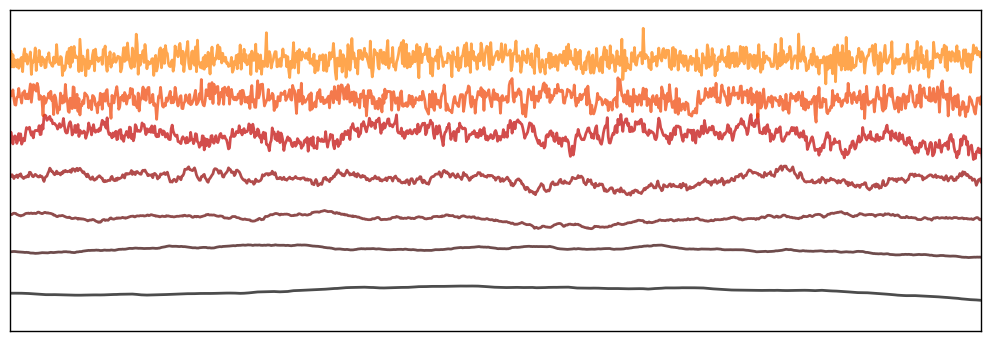

In [14]:
# Plot simulated time series, across 1/f properties
plot_multi_time_series(times, sigs, colors=cmap, xlim=[0, 1.0], xticks=[],
                       lw=2.0, alpha=0.7, xlabel=None, ylabel=None, 
                       figsize=(10, 3.5), **fsaver('time_series'))

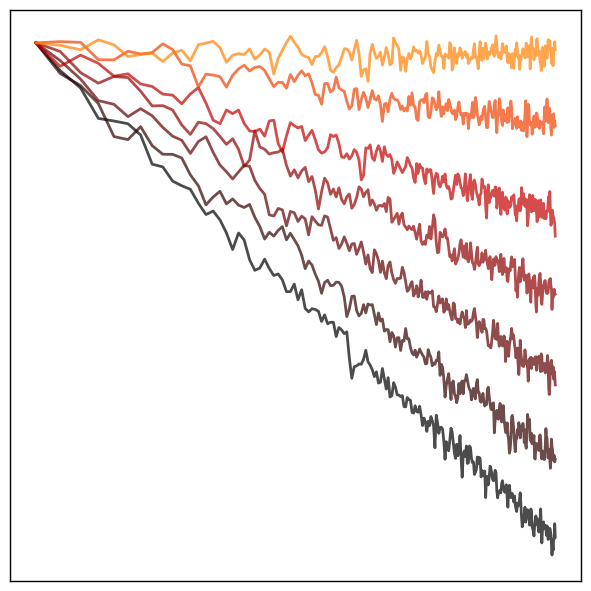

In [15]:
# Plot power spectra of different noise colours
plot_power_spectra(freqs, all_powers, colors=cmap, alpha=0.7, minorticks=False, lw=2,
                   xlabel=None, ylabel=None, xticks=[], yticks=[], **fsaver('power_spectra'))

## Measures

Next, we can introduce the different method categories to be examined in this project.

In [16]:
# Define list of measures
measures = ['autocorr', 'fluctuations', 'fractal', 'complexity', 'entropy', 'exponent']

In [17]:
# Define list of titles
titles = {
    'autocorr' : 'AutoCorrelation',
    'fluctuations' : 'Fluctuations',
    'fractal' : 'Fractal Dimension',
    'complexity' : 'Complexity',
    'entropy' : 'Entropy',
    'exponent' : 'Exponent',
}

In [18]:
# Compute measures
results = {measure : np.ones(len(sigs)) * np.nan for measure in measures}
for ind, sig in enumerate(sigs):
    results['autocorr'][ind] = autocorr_decay_time(sig, fs, level=0.1, max_lag=2000, lag_step=1)
    results['fluctuations'][ind] = dfa(sig, fs=fs)
    results['fractal'][ind] = higuchi_fd(sig)
    results['complexity'][ind] = lempelziv(sig)
    results['entropy'][ind] = app_entropy(sig)
    results['exponent'][ind] = specparam(sig, fs=fs)

## Visualize Method Results

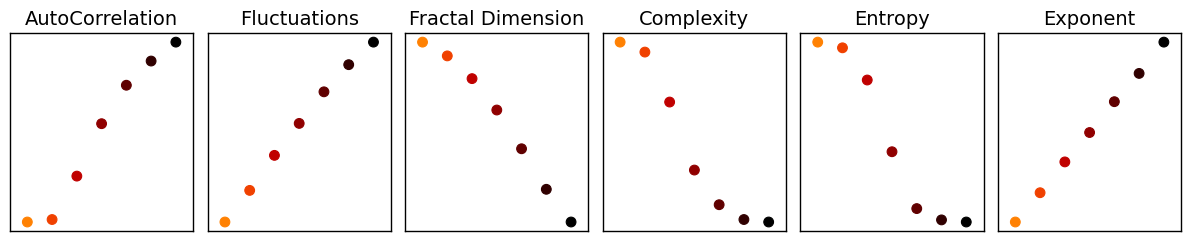

In [19]:
# Plot measure results all together
axes = make_axes(1, 6, figsize=(12, 2.5))
plot_dots(exps_viz, results['autocorr'], title=titles['autocorr'], ax=axes[0], **plt_kwargs)
plot_dots(exps_viz, results['fluctuations'], title=titles['fluctuations'], ax=axes[1], **plt_kwargs)
plot_dots(exps_viz, results['fractal'], title=titles['fractal'], ax=axes[2], **plt_kwargs)
plot_dots(exps_viz, results['complexity'], title=titles['complexity'], ax=axes[3], **plt_kwargs)
plot_dots(exps_viz, results['entropy'], title=titles['entropy'], ax=axes[4], **plt_kwargs)
plot_dots(exps_viz, results['exponent'], title=titles['exponent'], ax=axes[5], **plt_kwargs)

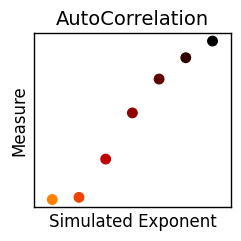

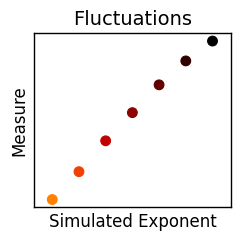

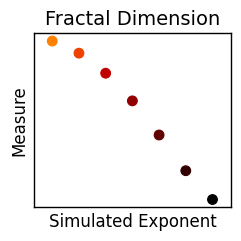

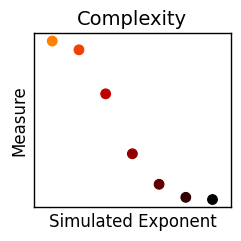

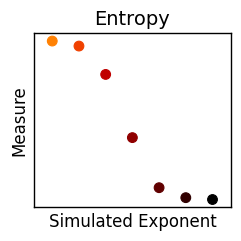

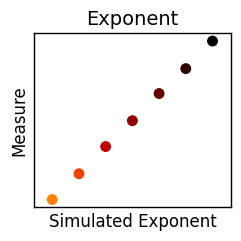

In [20]:
# Save out individual plots
for measure in measures:
    plot_dots(exps_viz, results[measure], title=titles[measure], **plt_kwargs, figsize=(2.5, 2.5),
              xlabel='Simulated Exponent', ylabel='Measure', label_size=12, **fsaver('plot_' + measure))

## Text Plot

This section makes an additional panel for the paper figure. 

In [21]:
# Define text plot settings
text_plt_kwargs = {
    'fontdict' : {'fontsize': 16},
    'horizontalalignment' : 'center',
}

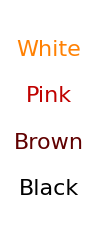

In [22]:
# Plot text labels
_, ax = plt.subplots(figsize=(1, 3))
ax.text(0.5, 0.80, 'White', color=cmap[6], **text_plt_kwargs)
ax.text(0.5, 0.60, 'Pink', color=cmap[4], **text_plt_kwargs)
ax.text(0.5, 0.40, 'Brown', color=cmap[2], **text_plt_kwargs)
ax.text(0.5, 0.20, 'Black', color=cmap[0], **text_plt_kwargs)
ax.axis('off');
if SAVE_FIG: plt.savefig(FIGPATH / ('noise_colors.pdf'))